### Notebook for hypothesis testing for scoreless matches in different leagues

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import math
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
conn = sqlite3.connect('database.sqlite')
c = conn.cursor()

In [3]:
#combine match data with league name
c.execute('''
            SELECT 
                   m.id,
                   l.name as league,
                   l.id as league_id,
                   m.season,
                   m.stage,
                   m.date,
                   m.match_api_id,
                   m.home_team_api_id,
                   m.away_team_api_id,
                   m.home_team_goal,
                   m.away_team_goal
            FROM Match m
            LEFT JOIN League l ON (m.league_id = l.id)
                                   
            ;''')

match_league = pd.DataFrame(c.fetchall())
match_league.columns = [i[0] for i in c.description]

In [4]:
#data preview
match_league.head()

,id,league,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,1,Belgium Jupiler League,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1
1,2,Belgium Jupiler League,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0
2,3,Belgium Jupiler League,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3
3,4,Belgium Jupiler League,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0
4,5,Belgium Jupiler League,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3


In [5]:
#calculate total match goals
match_league['total_goals'] = match_league['home_team_goal'] + match_league['away_team_goal']

In [6]:
#drop belgium league season 2013/2014 due to lack of information
match_league= match_league.loc[~((match_league['league'] == 'Belgium Jupiler League') & 
                     (match_league['season']=='2013/2014'))]

In [7]:
#retrieve match data for leagues in question
match_league= match_league.query('league_id == 1 | league_id == 13274 | league_id == 15722 \
                                  | league_id == 17642 | league_id == 19694 | league_id == 24558')

In [8]:
match_league.head()

,id,league,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,total_goals
0,1,Belgium Jupiler League,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,2
1,2,Belgium Jupiler League,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,0
2,3,Belgium Jupiler League,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,3
3,4,Belgium Jupiler League,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,5
4,5,Belgium Jupiler League,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,4


In [9]:
#inspect 'stage' column, 'stage' indicate match week
match_league['stage'].unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34,  4,  5,  6,  7,  8,  9,
       35, 36, 37, 38])

In [10]:
#create categorical variable for scoreless matches
match_league['scoreless'] = match_league['total_goals'].apply(lambda x: 1 if x==0 else 0)

In [11]:
match_league.head()

,id,league,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,total_goals,scoreless
0,1,Belgium Jupiler League,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,2,0
1,2,Belgium Jupiler League,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,0,1
2,3,Belgium Jupiler League,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,3,0
3,4,Belgium Jupiler League,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,5,0
4,5,Belgium Jupiler League,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,4,0


In [12]:
#aggregate match stats based on league, season and scoreless matches
match_scoreless_season = match_league.groupby(['league', 'season']).describe()['scoreless']

In [13]:
match_scoreless = match_league.groupby(['league', 'season', 'stage']).describe()['scoreless']

In [14]:
match_scoreless_season = match_scoreless_season[['count', 'mean']]

In [15]:
match_scoreless_season['matches_scoreless'] = match_scoreless_season['count']*match_scoreless_season['mean']

In [16]:
match_scoreless_season['pct_scoreless'] = match_scoreless_season['matches_scoreless']/match_scoreless_season['count']*100

In [17]:
match_scoreless_season

count      mean  matches_scoreless  \
league                   season                                          
Belgium Jupiler League   2008/2009  306.0  0.065359               20.0   
                         2009/2010  210.0  0.047619               10.0   
                         2010/2011  240.0  0.070833               17.0   
                         2011/2012  240.0  0.095833               23.0   
                         2012/2013  240.0  0.058333               14.0   
                         2014/2015  240.0  0.070833               17.0   
                         2015/2016  240.0  0.054167               13.0   
Netherlands Eredivisie   2008/2009  306.0  0.058824               18.0   
                         2009/2010  306.0  0.062092               19.0   
                         2010/2011  306.0  0.058824               18.0   
                         2011/2012  306.0  0.032680               10.0   
                         2012/2013  306.0  0.045752               14.0   
                         2013/2014  306.0  0.039216               12.0   
                         2014/2015  306.0  0.052288               16.0   
                         2015/2016  306.0  0.039216               12.0   
Poland Ekstraklasa       2008/2009  240.0  0.108333               26.0   
                         2009/2010  240.0  0.100000               24.0   
                         2010/2011  240.0  0.104167               25.0   
                         2011/2012  240.0  0.112500               27.0   
                         2012/2013  240.0  0.070833               17.0   
                         2013/2014  240.0  0.087500               21.0   
                         2014/2015  240.0  0.070833               17.0   
                         2015/2016  240.0  0.087500               21.0   
Portugal Liga ZON Sagres 2008/2009  240.0  0.112500               27.0   
                         2009/2010  240.0  0.116667               28.0   
                         2010/2011  240.0  0.100000               24.0   
                         2011/2012  240.0  0.100000               24.0   
                         2012/2013  240.0  0.058333               14.0   
                         2013/2014  240.0  0.079167               19.0   
                         2014/2015  306.0  0.091503               28.0   
                         2015/2016  306.0  0.068627               21.0   
Scotland Premier League  2008/2009  228.0  0.087719               20.0   
                         2009/2010  228.0  0.100877               23.0   
                         2010/2011  228.0  0.057018               13.0   
                         2011/2012  228.0  0.109649               25.0   
                         2012/2013  228.0  0.100877               23.0   
                         2013/2014  228.0  0.057018               13.0   
                         2014/2015  228.0  0.039474                9.0   
                         2015/2016  228.0  0.065789               15.0   
Switzerland Super League 2008/2009  180.0  0.072222               13.0   
                         2009/2010  180.0  0.027778                5.0   
                         2010/2011  180.0  0.044444                8.0   
                         2011/2012  162.0  0.086420               14.0   
                         2012/2013  180.0  0.077778               14.0   
                         2013/2014  180.0  0.066667               12.0   
                         2014/2015  180.0  0.077778               14.0   
                         2015/2016  180.0  0.038889                7.0   

                                    pct_scoreless  
league                   season                    
Belgium Jupiler League   2008/2009       6.535948  
                         2009/2010       4.761905  
                         2010/2011       7.083333  
                         2011/2012       9.583333  
                         2012/2013       5.833333  
                         2014/2015       7.08

In [18]:
match_scoreless_league = match_league.groupby(['league']).describe()['scoreless']

In [19]:
match_scoreless_league = match_scoreless_league[['count', 'mean']]
match_scoreless_league['matches_scoreless'] = match_scoreless_league['count']*match_scoreless_league['mean']
match_scoreless_league['pct_scoreless'] = match_scoreless_league['matches_scoreless']/match_scoreless_league['count']*100

In [20]:
match_scoreless_league

,count,mean,matches_scoreless,pct_scoreless
league,,,,
Belgium Jupiler League,1716.0,0.066434,114.0,6.643357
Netherlands Eredivisie,2448.0,0.048611,119.0,4.861111
Poland Ekstraklasa,1920.0,0.092708,178.0,9.270833
Portugal Liga ZON Sagres,2052.0,0.090156,185.0,9.015595
Scotland Premier League,1824.0,0.077303,141.0,7.730263
Switzerland Super League,1422.0,0.061181,87.0,6.118143


In [21]:
test_df = match_scoreless[['count','mean']]

In [22]:
match_scoreless.index.get_level_values('league')

Index(['Belgium Jupiler League', 'Belgium Jupiler League',
       'Belgium Jupiler League', 'Belgium Jupiler League',
       'Belgium Jupiler League', 'Belgium Jupiler League',
       'Belgium Jupiler League', 'Belgium Jupiler League',
       'Belgium Jupiler League', 'Belgium Jupiler League',
       ...
       'Switzerland Super League', 'Switzerland Super League',
       'Switzerland Super League', 'Switzerland Super League',
       'Switzerland Super League', 'Switzerland Super League',
       'Switzerland Super League', 'Switzerland Super League',
       'Switzerland Super League', 'Switzerland Super League'],
      dtype='object', name='league', length=1566)

In [23]:
#function for retrieving league data as an array
def get_league_data(match_df, league_name):
    league_df = match_df.loc[match_df.index.get_level_values('league')==league_name][['count','mean']]
    league_df['num'] = league_df['count']*league_df['mean']
    league_array = np.array(league_df['mean'])
    
    return league_array*100

In [24]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [25]:
#separate data into series by league
bel_scoreless = get_league_data(match_scoreless, 'Belgium Jupiler League')
ned_scoreless = get_league_data(match_scoreless, 'Netherlands Eredivisie')
pol_scoreless = get_league_data(match_scoreless, 'Poland Ekstraklasa')
prt_scoreless = get_league_data(match_scoreless, 'Portugal Liga ZON Sagres')
sct_scoreless = get_league_data(match_scoreless, 'Scotland Premier League')
sui_scoreless = get_league_data(match_scoreless, 'Scotland Premier League')

In [26]:
#dutch league has lowest average percentage of scoreless games, use as benchmark for testing
bel_scoreless.mean(), ned_scoreless.mean(), pol_scoreless.mean(), prt_scoreless.mean(), sct_scoreless.mean(), sui_scoreless.mean()

(6.612520397567127,
 4.861111111111111,
 9.270833333333334,
 9.050179211469533,
 7.730263157894735,
 7.730263157894735)

In [27]:
#null hypothesis - there is no statistical difference in the percentage of scoreless matches between the Dutch league and other leagues
#alternative hypothesis - there is statistical difference in the Dutch league and the other leagues with Dutch league having
#lower percentage of scoreless matches

#result - rejected null hypothesis

In [28]:
#NED vs. BEL
t,p = stats.ttest_ind(ned_scoreless, bel_scoreless, equal_var=False)
p/2, abs(Cohen_d(ned_scoreless, bel_scoreless))

(0.011293981412264013, 0.216168397232261)

In [29]:
#NED vs. SUI
t, p = stats.ttest_ind(ned_scoreless, sui_scoreless, equal_var=False)
p/2, abs(Cohen_d(ned_scoreless, sui_scoreless))

(0.0001461004274129247, 0.29746883081130093)

In [30]:
t, p = stats.ttest_ind(ned_scoreless, pol_scoreless, equal_var=False)
p/2, abs(Cohen_d(ned_scoreless, pol_scoreless))

(5.483984281754976e-08, 0.49162332667166597)

In [31]:
t, p = stats.ttest_ind(ned_scoreless, prt_scoreless, equal_var=False)
p/2, abs(Cohen_d(ned_scoreless, prt_scoreless))

(6.563818530760138e-08, 0.47973797139417246)

In [32]:
t, p = stats.ttest_ind(ned_scoreless, sct_scoreless, equal_var=False)
p/2, abs(Cohen_d(ned_scoreless, sct_scoreless))

(0.0001461004274129247, 0.29746883081130093)

In [33]:
#test for matches with two or more goals scored

In [34]:
match_league['goals_2plus'] = match_league['total_goals'].apply(lambda x: 1 if x>1 else 0)

In [35]:
match_league.head()

,id,league,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,total_goals,scoreless,goals_2plus
0,1,Belgium Jupiler League,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,2,0,1
1,2,Belgium Jupiler League,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,0,1,0
2,3,Belgium Jupiler League,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,3,0,1
3,4,Belgium Jupiler League,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,5,0,1
4,5,Belgium Jupiler League,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,4,0,1


In [36]:
match_goals_2plus = match_league.groupby(['league', 'season', 'stage']).describe()['goals_2plus']

In [37]:
match_goals_2plus

count      mean       std  min  25%  \
league                   season    stage                                        
Belgium Jupiler League   2008/2009 1        9.0  0.777778  0.440959  0.0  1.0   
                                   2        9.0  0.888889  0.333333  0.0  1.0   
                                   3        9.0  0.777778  0.440959  0.0  1.0   
                                   4        9.0  0.888889  0.333333  0.0  1.0   
                                   5        9.0  0.333333  0.500000  0.0  0.0   
                                   6        9.0  0.888889  0.333333  0.0  1.0   
                                   7        9.0  0.777778  0.440959  0.0  1.0   
                                   8        9.0  0.888889  0.333333  0.0  1.0   
                                   9        9.0  0.777778  0.440959  0.0  1.0   
                                   10       9.0  0.777778  0.440959  0.0  1.0   
                                   11       9.0  0.666667  0.500000  0.0  0.0   
                                   12       9.0  0.777778  0.440959  0.0  1.0   
                                   13       9.0  0.888889  0.333333  0.0  1.0   
                                   14       9.0  0.888889  0.333333  0.0  1.0   
                                   15       9.0  0.888889  0.333333  0.0  1.0   
                                   16       9.0  0.888889  0.333333  0.0  1.0   
                                   17       9.0  0.888889  0.333333  0.0  1.0   
                                   18       9.0  1.000000  0.000000  1.0  1.0   
                                   19       9.0  0.666667  0.500000  0.0  0.0   
                                   20       9.0  1.000000  0.000000  1.0  1.0   
                                   21       9.0  0.888889  0.333333  0.0  1.0   
                                   22       9.0  0.666667  0.500000  0.0  0.0   
                                   23       9.0  0.888889  0.333333  0.0  1.0   
                                   24       9.0  0.888889  0.333333  0.0  1.0   
                                   25       9.0  0.666667  0.500000  0.0  0.0   
                                   26       9.0  0.555556  0.527046  0.0  0.0   
                                   27       9.0  0.555556  0.527046  0.0  0.0   
                                   28       9.0  0.777778  0.440959  0.0  1.0   
                                   29       9.0  0.444444  0.527046  0.0  0.0   
                                   30       9.0  0.666667  0.500000  0.0  0.0   
...                                         ...       ...       ...  ...  ...   
Switzerland Super League 2015/2016 7        5.0  0.600000  0.547723  0.0  0.0   
                                   8        5.0  1.000000  0.000000  1.0  1.0   
                                   9        5.0  0.600000  0.547723  0.0  0.0   
                                   10       5.0  0.400000  0.547723  0.0  0.0   
                                   11       5.0  1.000000  0.000000  1.0  1.0   
                                   12       5.0  0.800000  0.447214  0.0  1.0   
                                   13       5.0  0.800000  0.447214  0.0  1.0   
                                   14       5.0  0.800000  0.447214  0.0  1.0   
                                   15       5.0  1.000000  0.000000  1.0  1.0   
                                   16       5.0  0.800000  0.447214  0.0  1.0   
                                   17       5.0  1.000000  0.000000  1.0  1.0   
                                   18       5.0  0.800000  0.447214  0.0  1.0   
                                   19       5.0  0.800000  0.447214  0.0  1.0   
                                   20       5.0  1.000000  0.000000  1.0  1.0   
                                   21       5.0  0.600000  0.547723  0.0  0.0   
                                   22       5.0  0.800000  0.447214  0.0  1.0   
                                   23       5.0  0.800000  0.447214  0.0 

In [38]:
bel_2plus = get_league_data(match_goals_2plus, 'Belgium Jupiler League')
ned_2plus = get_league_data(match_goals_2plus, 'Netherlands Eredivisie')
pol_2plus = get_league_data(match_goals_2plus, 'Poland Ekstraklasa')
prt_2plus = get_league_data(match_goals_2plus, 'Portugal Liga ZON Sagres')
sui_2plus = get_league_data(match_goals_2plus, 'Switzerland Super League')
sct_2plus = get_league_data(match_goals_2plus, 'Scotland Premier League')

In [39]:
bel_2plus.mean(), ned_2plus.mean(), pol_2plus.mean(), prt_2plus.mean(), sui_2plus.mean(), sct_2plus.mean()

(77.7128764278297,
 82.63888888888889,
 70.3125,
 69.87007168458783,
 78.40277777777777,
 73.84868421052632)

In [40]:
stats.ttest_ind(ned_2plus, bel_2plus, equal_var=False)

Ttest_indResult(statistic=3.9014465592171597, pvalue=0.0001107444291663613)

In [41]:
stats.ttest_ind(ned_2plus, pol_2plus, equal_var=False)

Ttest_indResult(statistic=8.85856256430822, pvalue=2.0812614703060922e-17)

In [42]:
stats.ttest_ind(ned_2plus, prt_2plus, equal_var=False)

Ttest_indResult(statistic=9.85882209306678, pvalue=5.482415915492024e-21)

In [43]:
stats.ttest_ind(ned_2plus, sui_2plus, equal_var=False)

Ttest_indResult(statistic=3.1660454184002726, pvalue=0.0016358556466105042)

In [44]:
stats.ttest_ind(ned_2plus, sct_2plus, equal_var=False)

Ttest_indResult(statistic=6.7117289399519775, pvalue=4.802680221691386e-11)

In [45]:
#3plus goals
match_league['goals_3plus'] = match_league['total_goals'].apply(lambda x: 1 if x>2 else 0)

In [46]:
match_goals_3plus = match_league.groupby(['league', 'season', 'stage']).describe()['goals_3plus']

In [47]:
bel_3plus = get_league_data(match_goals_3plus, 'Belgium Jupiler League')
ned_3plus = get_league_data(match_goals_3plus, 'Netherlands Eredivisie')
pol_3plus = get_league_data(match_goals_3plus, 'Poland Ekstraklasa')
prt_3plus = get_league_data(match_goals_3plus, 'Portugal Liga ZON Sagres')
sui_3plus = get_league_data(match_goals_3plus, 'Switzerland Super League')
sct_3plus = get_league_data(match_goals_3plus, 'Scotland Premier League')

In [48]:
bel_3plus.mean(), ned_3plus.mean(), pol_3plus.mean(), prt_3plus.mean(), sui_3plus.mean(), sct_3plus.mean()

(52.798175344904315,
 58.21078431372548,
 43.854166666666664,
 46.4437724014337,
 55.989583333333336,
 49.945175438596486)

In [49]:
stats.ttest_ind(ned_3plus, bel_3plus, equal_var=False)

Ttest_indResult(statistic=3.3939164474123227, pvalue=0.000749630301189746)

In [50]:
stats.ttest_ind(ned_3plus, pol_3plus, equal_var=False)

Ttest_indResult(statistic=9.11587647100637, pvalue=1.966936714581481e-18)

In [51]:
stats.ttest_ind(ned_3plus, prt_3plus, equal_var=False)

Ttest_indResult(statistic=7.597408239963209, pvalue=1.4625002338742121e-13)

In [52]:
stats.ttest_ind(ned_3plus, sui_3plus, equal_var=False)

Ttest_indResult(statistic=1.3291654136316824, pvalue=0.184356192321847)

In [53]:
stats.ttest_ind(ned_3plus, sct_3plus, equal_var=False)

Ttest_indResult(statistic=5.060093149950364, pvalue=5.67622575738273e-07)

In [54]:
#match_scoreless_season

In [55]:
match_scoreless_league

,count,mean,matches_scoreless,pct_scoreless
league,,,,
Belgium Jupiler League,1716.0,0.066434,114.0,6.643357
Netherlands Eredivisie,2448.0,0.048611,119.0,4.861111
Poland Ekstraklasa,1920.0,0.092708,178.0,9.270833
Portugal Liga ZON Sagres,2052.0,0.090156,185.0,9.015595
Scotland Premier League,1824.0,0.077303,141.0,7.730263
Switzerland Super League,1422.0,0.061181,87.0,6.118143


In [56]:
lg = list(match_scoreless_league['mean'].index)
lg_abbr = ['BEL', 'NED', 'POL', 'PRT', 'SCT', 'SUI']
lg_mu = match_scoreless_league['pct_scoreless']

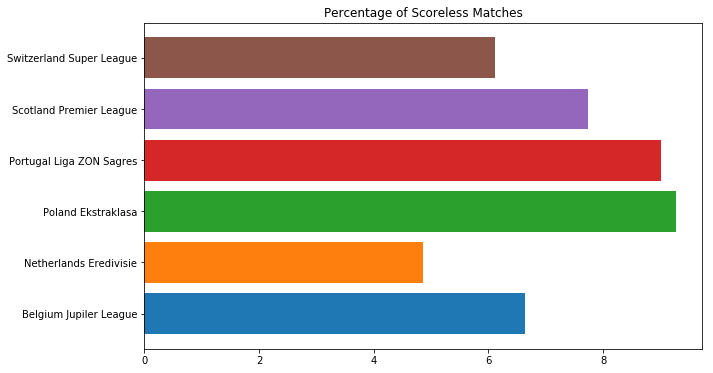

In [58]:
plt.figure(figsize=(10,6));
plt.barh(lg[0], lg_mu[0]);
plt.barh(lg[1], lg_mu[1]);
plt.barh(lg[2], lg_mu[2]);
plt.barh(lg[3], lg_mu[3]);
plt.barh(lg[4], lg_mu[4]);
plt.barh(lg[5], lg_mu[5]);
plt.title('Percentage of Scoreless Matches');
